In [2]:
from pathlib import Path
from act_pol.analysis.files import process_sim
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, maxwell, norm
from utils import plot
from utils.plot import cm
from matplotlib.lines import Line2D
np.random.seed(seed=42)

In [3]:
class Simulation:
    """A class to process simulation data."""

    def __init__(self, *, B, F, A, L, R, b=1, directory="simulations", unitful=False):
        self.path = Path(f"./{directory}/B{B:.3g}_F{F:.3g}_A{A:.3g}_L{L:.3g}_R{R:.3g}/")
        print(self.path)
        self.files = list(self.path.glob("tape*.csv"))
        
        # Constants
        kb = 80.10471204188482 # nm per kb
        
        # Define unitful length scale
        self.Lk = 35.36  # Kuhn length in nm

        # Get simulation parameters
        self.Lc = 250*kb
        self.N = round(self.Lc/self.Lk) + 1  # Number of beads
        self.b = 1
        self.Lep = round(L*kb/self.Lk)
        self.Lp = self.b/2
        self.R = 250/self.Lk
        self.mid = (self.N-1)/2
        self.s1 = round(self.mid - self.Lep/2)  # Enhancer position
        self.s2 = round(self.mid + self.Lep/2)  # Promoter position
        self.Nep = self.s2-self.s1
        
        if unitful:
            conversion = self.Lk
            self.b = self.b*self.Lk
            self.Lep = self.Lep*self.Lk
            self.Lp = self.Lp*self.Lk
            self.R = self.R*self.Lk
        else:
            conversion = 1
        print(self.Lep)

        # Compute displacement
        numpyfile = self.path/"concatenated_results.npy"
        if (numpyfile).exists:
            self.displacement = np.squeeze(np.load(numpyfile))
        else:
            self.displacement = np.squeeze(
                np.vstack([
                    np.diff(process_sim(file)[0][:, [self.s1, self.s2], :], axis=1)
                    for file in self.files
                ])
                )
        # Convert length data to unitful quantities if unitful=True
        self.displacement = self.displacement*conversion

        # Generate Gaussian KDEs for displacement
        self.displacement_g = [
            gaussian_kde(self.displacement[:, i]) 
            for i in range(self.displacement.shape[1])
        ]

        # Compute 1D Gaussians of variance Nb^2/3
        gaussian_1D_prefactor = (3/(2*np.pi*self.Nep*self.b**2))**(1/2)
        self.gaussian_1D = lambda r: gaussian_1D_prefactor*np.exp(-3/(2*self.Nep*self.b**2)*r**2)
        self.gaussian_1D_rv = norm(scale=np.sqrt(self.Nep*self.b**2/3))
        
        # Compute distance and its Gaussian KDE
        # If unitful=True, there's no need to convert again since we use displacement data
        self.distance = np.linalg.norm(self.displacement, axis=1)
        self.distance_g = gaussian_kde(self.distance)
        
        # Compute maxwell distribution
        maxwell_prefactor = 4*np.pi*(3/(4*self.Lep*self.Lp)/np.pi)**(3/2)
        self.maxwell = lambda r: maxwell_prefactor*r**2*np.exp(-3/(4*self.Lep*self.Lp)*(r**2))
        self.maxwell_rv = maxwell(scale=np.sqrt(2*self.Lep*self.Lp/3))

def hist(ax,arr,density=True,fill=False,histtype='step',linewidth=1.5,**kwargs):
    """Plot a histogram with pre-defined kwargs."""
    ax.hist(arr,density=density,fill=fill,histtype=histtype,linewidth=linewidth,**kwargs)

def histlegend(ax,**kwargs):
    """Convert step legend handles to lines."""
    
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [
        h if isinstance(h, Line2D) else Line2D([], [], c=h.get_edgecolor())
        for h in handles
    ]
    ax.legend(handles=new_handles, labels=labels,**kwargs)

In [5]:
"""Equilibrium distribution"""
sim = Simulation(B=0,F=1,A=1,L=150,R=0)

simulations/B0_F1_A1_L150_R0
340


Text(0.5, 1.0, '$\\beta=0,A=1,\\xi=1$')

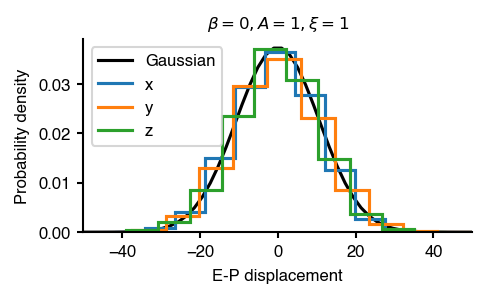

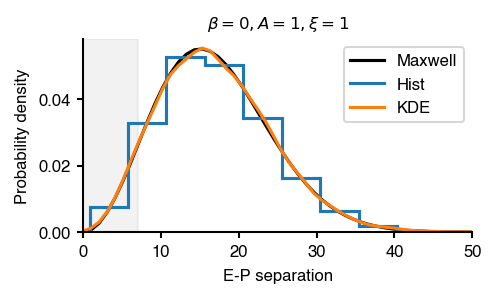

In [6]:
fig, ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P displacement")
r = np.linspace(-50,50)
ax.plot(r,sim.gaussian_1D_rv.pdf(r),label="Gaussian",color="black")
hist(ax,sim.displacement[:,0],label="x")
hist(ax,sim.displacement[:,1],label="y")
hist(ax,sim.displacement[:,2],label="z")
histlegend(ax)
ax.set_xlim(-50,50)
ax.set_title(r"$\beta=0,A=1,\xi=1$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.maxwell(r),label="Maxwell",color="black")
hist(ax,sim.distance,label="Hist")
ax.plot(r,sim.distance_g(r),label="KDE")
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_xlim(0,50)
# ax.plot(r,sim.maxwell_rv.pdf(r),label="Maxwell (Scipy)")
histlegend(ax)
ax.set_title(r"$\beta=0,A=1,\xi=1$")

In [7]:
"""Zero flow, increase friction only, for two contour lengths"""
perturb_F_150 = [Simulation(B=0,F=n,A=1,L=150,R=0) for n in [14,100]]
perturb_F_20 = [Simulation(B=0,F=n,A=1,L=20,R=0) for n in [14,100]]

simulations/B0_F14_A1_L150_R0
340
simulations/B0_F100_A1_L150_R0
340
simulations/B0_F14_A1_L20_R0
45
simulations/B0_F100_A1_L20_R0
45


Text(0.5, 1.0, '$\\beta=0,A=1,Lc=150\\mathrm{kb}$')

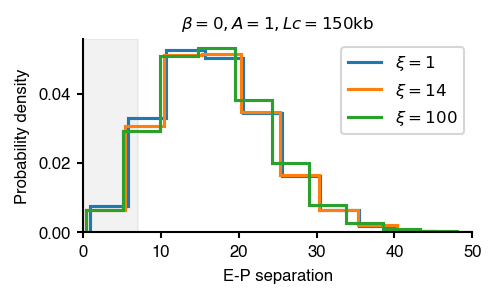

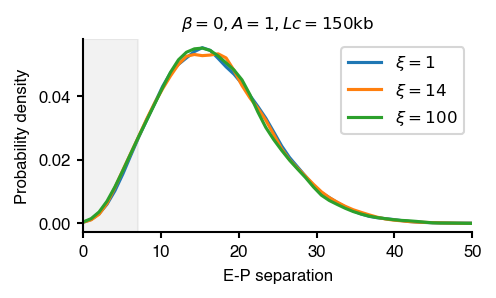

In [8]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,sim.distance,label=r"$\xi=1$")
hist(ax,perturb_F_150[0].distance,label=r"$\xi=14$")
hist(ax,perturb_F_150[1].distance,label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=0,A=1,Lc=150\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,sim.distance_g(r),label=r"$\xi=1$")
ax.plot(r,perturb_F_150[0].distance_g(r),label=r"$\xi=14$")
ax.plot(r,perturb_F_150[1].distance_g(r),label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=0,A=1,Lc=150\mathrm{kb}$")

Text(0.5, 1.0, '$\\beta=0,A=1,Lc=20\\mathrm{kb}$')

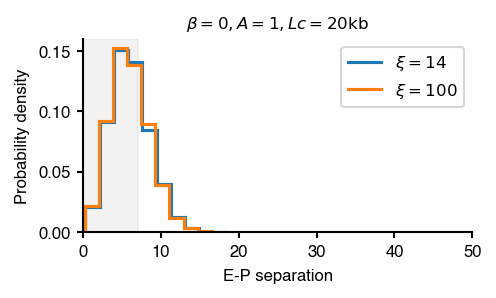

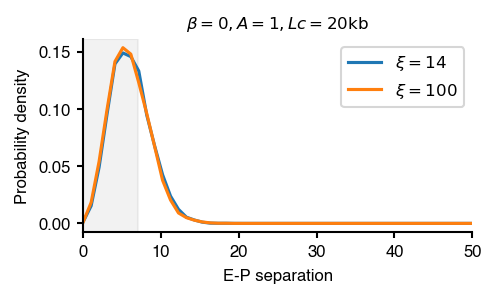

In [9]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_F_20[0].distance,label=r"$\xi=14$")
hist(ax,perturb_F_20[1].distance,label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=0,A=1,Lc=20\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_F_20[0].distance_g(r),label=r"$\xi=14$")
ax.plot(r,perturb_F_20[1].distance_g(r),label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=0,A=1,Lc=20\mathrm{kb}$")

In [10]:
"""Zero flow, decrease activity only, for two contour lengths"""
perturb_A_150 = [Simulation(B=0,F=1,A=n,L=150,R=0) for n in [0,10]]
perturb_A_20 = [Simulation(B=0,F=1,A=n,L=150,R=0) for n in [0,10]]

simulations/B0_F1_A0_L150_R0
340
simulations/B0_F1_A10_L150_R0
340
simulations/B0_F1_A0_L150_R0
340
simulations/B0_F1_A10_L150_R0
340


Text(0.5, 1.0, '$\\beta=0,\\xi=1,Lc=150\\mathrm{kb}$')

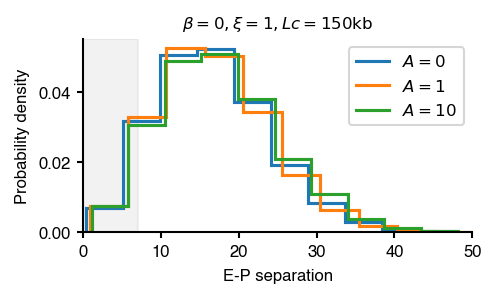

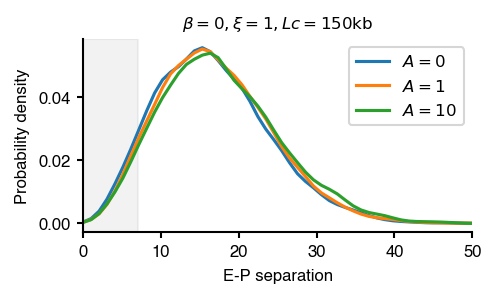

In [11]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
hist(ax,perturb_A_150[0].distance,label=r"$A=0$")
hist(ax,sim.distance,label=r"$A=1$")
hist(ax,perturb_A_150[1].distance,label=r"$A=10$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=0,\xi=1,Lc=150\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_A_150[0].distance_g(r),label=r"$A=0$")
ax.plot(r,sim.distance_g(r),label=r"$A=1$")
ax.plot(r,perturb_A_150[1].distance_g(r),label=r"$A=10$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=0,\xi=1,Lc=150\mathrm{kb}$")

Text(0.5, 1.0, '$\\beta=0,\\xi=1,Lc=20\\mathrm{kb}$')

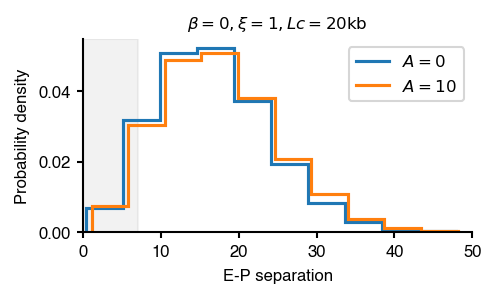

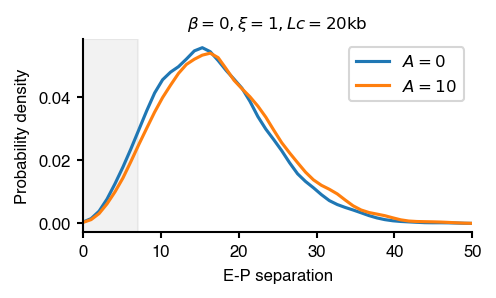

In [12]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
ax.set_xlim(0,50)
hist(ax,perturb_A_20[0].distance,label=r"$A=0$")
hist(ax,perturb_A_20[1].distance,label=r"$A=10$")
histlegend(ax)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=0,\xi=1,Lc=20\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.set_xlim(0,50)
ax.plot(r,perturb_A_20[0].distance_g(r),label=r"$A=0$")
ax.plot(r,perturb_A_20[1].distance_g(r),label=r"$A=10$")
histlegend(ax)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=0,\xi=1,Lc=20\mathrm{kb}$")

In [13]:
"""Finite flow, increase friction only, for two contour lengths"""
perturb_BF_10_150 = [Simulation(B=10,F=n,A=1,L=150,R=0) for n in [14,100]]
perturb_BF_10_20 = [Simulation(B=10,F=n,A=1,L=20,R=0) for n in [14,100]]
perturb_BF_20_150 = [Simulation(B=20,F=n,A=1,L=150,R=0) for n in [14,100]]
perturb_BF_20_20 = [Simulation(B=20,F=n,A=1,L=20,R=0) for n in [14,100]]

simulations/B10_F14_A1_L150_R0
340
simulations/B10_F100_A1_L150_R0
340
simulations/B10_F14_A1_L20_R0
45
simulations/B10_F100_A1_L20_R0
45
simulations/B20_F14_A1_L150_R0
340
simulations/B20_F100_A1_L150_R0
340
simulations/B20_F14_A1_L20_R0
45
simulations/B20_F100_A1_L20_R0
45


Text(0.5, 1.0, '$\\beta=10,A=1,Lc=150\\mathrm{kb}$')

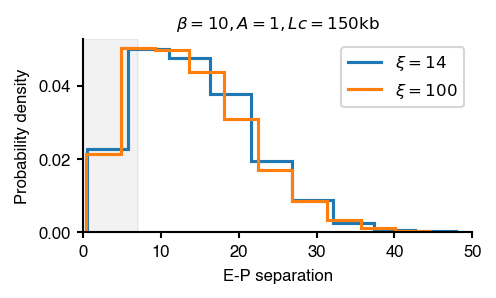

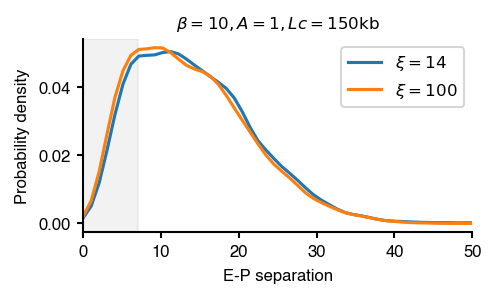

In [14]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_BF_10_150[0].distance,label=r"$\xi=14$")
hist(ax,perturb_BF_10_150[1].distance,label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=10,A=1,Lc=150\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_BF_10_150[0].distance_g(r),label=r"$\xi=14$")
ax.plot(r,perturb_BF_10_150[1].distance_g(r),label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=10,A=1,Lc=150\mathrm{kb}$")

Text(0.5, 1.0, '$\\beta=10,A=1,Lc=20\\mathrm{kb}$')

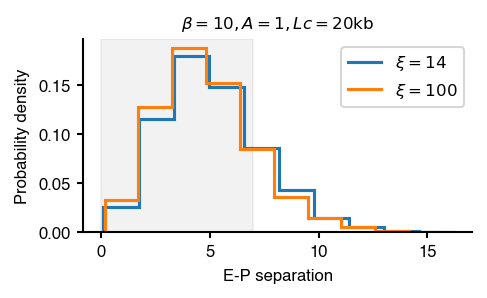

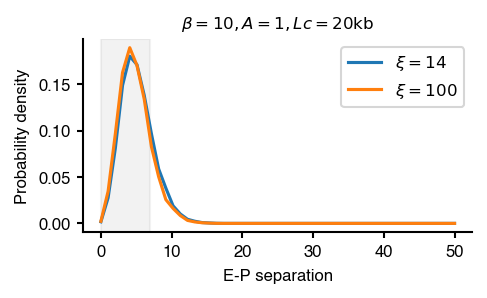

In [15]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
hist(ax,perturb_BF_10_20[0].distance,label=r"$\xi=14$")
hist(ax,perturb_BF_10_20[1].distance,label=r"$\xi=100$")
histlegend(ax)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=10,A=1,Lc=20\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_BF_10_20[0].distance_g(r),label=r"$\xi=14$")
ax.plot(r,perturb_BF_10_20[1].distance_g(r),label=r"$\xi=100$")
histlegend(ax)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=10,A=1,Lc=20\mathrm{kb}$")

Text(0.5, 1.0, '$\\beta=20,A=1,Lc=150\\mathrm{kb}$')

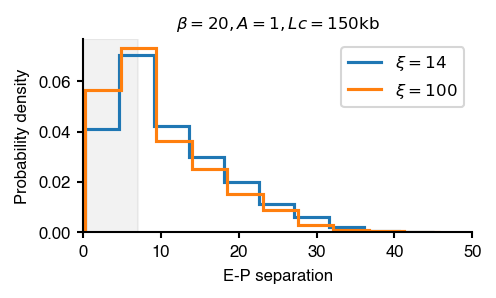

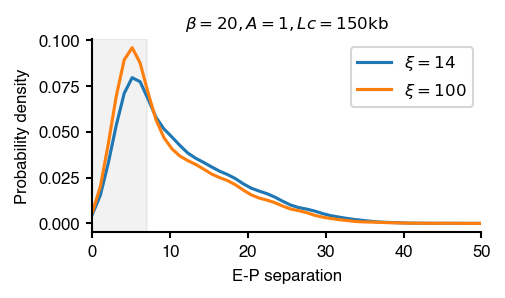

In [16]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_BF_20_150[0].distance,label=r"$\xi=14$")
hist(ax,perturb_BF_20_150[1].distance,label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=20,A=1,Lc=150\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_BF_20_150[0].distance_g(r),label=r"$\xi=14$")
ax.plot(r,perturb_BF_20_150[1].distance_g(r),label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=20,A=1,Lc=150\mathrm{kb}$")

Text(0.5, 1.0, '$\\beta=20,A=1,Lc=20\\mathrm{kb}$')

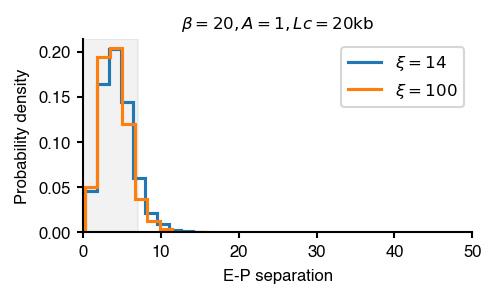

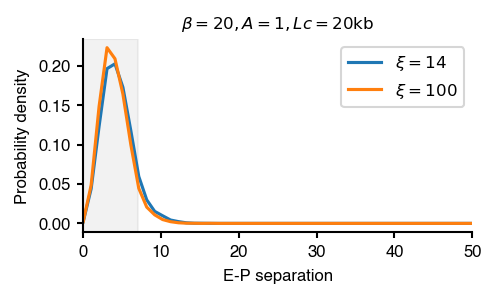

In [17]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
hist(ax,perturb_BF_20_20[0].distance,label=r"$\xi=14$")
hist(ax,perturb_BF_20_20[1].distance,label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=20,A=1,Lc=20\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_BF_20_20[0].distance_g(r),label=r"$\xi=14$")
ax.plot(r,perturb_BF_20_20[1].distance_g(r),label=r"$\xi=100$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=20,A=1,Lc=20\mathrm{kb}$")

In [18]:
"""Finite flow, decrease activity only, for two contour lengths"""
perturb_BA_10_150 = Simulation(B=10,F=1,A=0,L=150,R=0)
perturb_BA_10_20 = Simulation(B=10,F=1,A=0,L=20,R=0)
perturb_BA_20_150 = Simulation(B=20,F=1,A=0,L=150,R=0)
perturb_BA_20_20 = Simulation(B=20,F=1,A=0,L=20,R=0)

simulations/B10_F1_A0_L150_R0
340
simulations/B10_F1_A0_L20_R0
45
simulations/B20_F1_A0_L150_R0
340
simulations/B20_F1_A0_L20_R0
45


Text(0.5, 1.0, '$\\beta=10,A=1,Lc=150\\mathrm{kb}$')

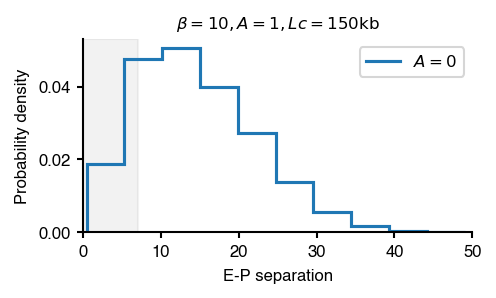

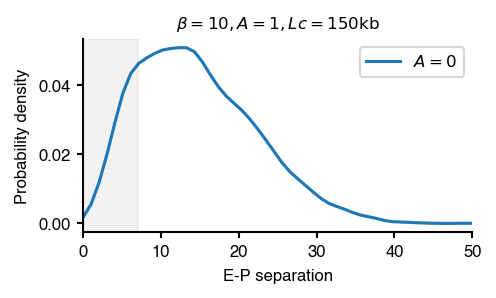

In [19]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_BA_10_150.distance,label=r"$A=0$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=10,A=1,Lc=150\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_BA_10_150.distance_g(r),label=r"$A=0$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=10,A=1,Lc=150\mathrm{kb}$")

Text(0.5, 1.0, '$\\beta=10,A=1,Lc=20\\mathrm{kb}$')

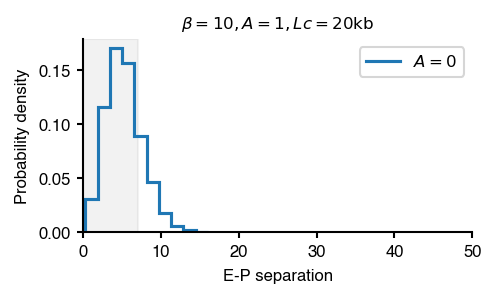

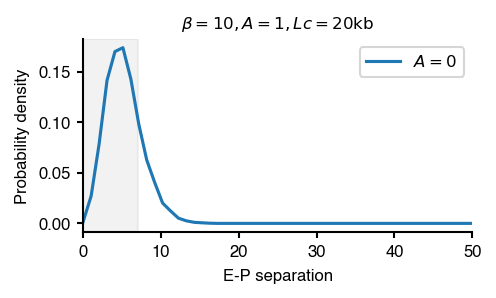

In [20]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_BA_10_20.distance,label=r"$A=0$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=10,A=1,Lc=20\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_BA_10_20.distance_g(r),label=r"$A=0$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=10,A=1,Lc=20\mathrm{kb}$")

Text(0.5, 1.0, '$\\beta=20,A=1,Lc=150\\mathrm{kb}$')

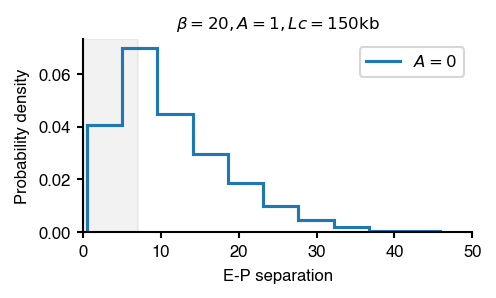

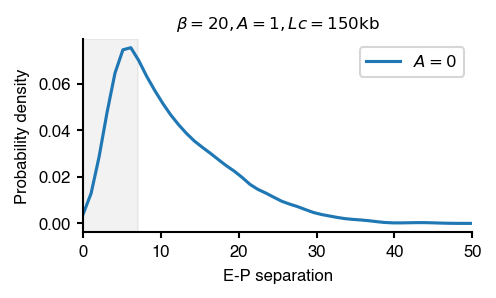

In [21]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_BA_20_150.distance,label=r"$A=0$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=20,A=1,Lc=150\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_BA_20_150.distance_g(r),label=r"$A=0$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=20,A=1,Lc=150\mathrm{kb}$")

Text(0.5, 1.0, '$\\beta=20,A=1,Lc=20\\mathrm{kb}$')

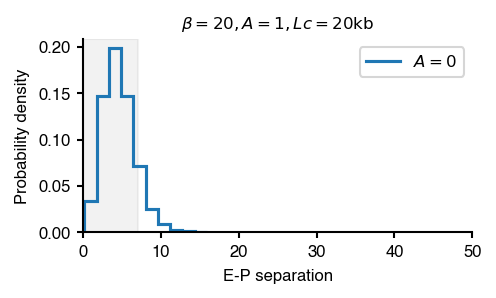

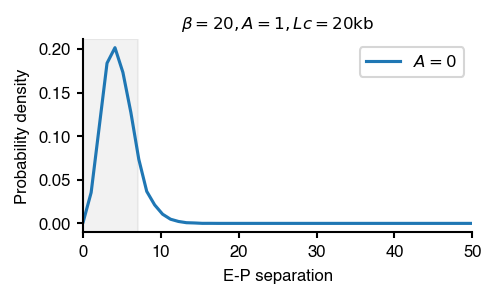

In [22]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
hist(ax,perturb_BA_20_20.distance,label=r"$A=0$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=20,A=1,Lc=20\mathrm{kb}$")

fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
ax.plot(r,perturb_BA_20_20.distance_g(r),label=r"$A=0$")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)
ax.set_title(r"$\beta=20,A=1,Lc=20\mathrm{kb}$")

In [ ]:
perturb_BF_10_150 = Simulation(B=10,F=14,A=1,L=150,R=0)
perturb_BF_10_150_R = Simulation(B=10,F=14,A=1,L=150,R=1)

In [ ]:
perturb_BF_20_150 = [Simulation(B=20,F=n,A=1,L=150,R=0) for n in [14,100]]

In [ ]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
# hist(ax,perturb_BF_10_150.distance,label="10 Non-reciprocal")
hist(ax,perturb_BF_10_150_R.distance,label="10 Reciprocal",bins=30)
hist(ax,perturb_BF_20_150[0].distance,label="20 Non-reciprocal",bins=30)
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)

In [ ]:
fig,ax = plt.subplots(figsize=(8.5*cm,8.5*cm/2))
ax.set_ylabel("Probability density")
ax.set_xlabel("E-P separation")
r = np.linspace(0,50)
# hist(ax,perturb_BF_10_150.distance,label="10 Non-reciprocal")
ax.plot(r,perturb_BF_10_150_R.distance_g(r),label="10 Reciprocal")
ax.plot(r,perturb_BF_20_150[0].distance_g(r),label="20 Non-reciprocal")
histlegend(ax)
ax.set_xlim(0,50)
ax.axvspan(0,7,color="grey",alpha=0.1)